In [3]:
import importlib

import os
import torch
import datetime
import pandas as pd
import utils as ut
import plotly.express as px

import geopandas as gp
from torch.autograd import Variable
import matplotlib.pyplot as plt

import paths
from apollo import mechanics as ma
from apollo import streamflow as strf
from apollo import metrics as me

from train_model import load_data, train
from train_model import sensitivity_analysis as sa

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

pd.options.mode.chained_assignment = None

In [9]:
### Set global model parameters
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Rundown code and dataloading step by step

In [28]:
station = 54057
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))

In [29]:
metadata = pd.read_csv(paths.DATA + '/Catchment_Database.csv')
specific = metadata[metadata['Station number'] == station]

In [91]:
filename = paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_lumped_linear.csv')
rf = pd.read_csv(filename)
#rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
rf = rf.drop(rf.index[:215])
len_before = len(rf)
rf = rf.dropna(subset=['Flow'])
print(len_before-len(rf), 'values are missing.')
rf

123 values are missing.


Unnamed: 0        Date   Flow  Temperature  U Windspeed  V Windspeed  \
215           394  1980-01-30  120.0   280.789502     4.509026     2.505066   
216           395  1980-01-31  175.0   280.699881    -0.014218     1.717637   
217           396  1980-02-01  267.0   273.577899     1.297784     1.229929   
218           397  1980-02-02  254.0   280.777470     4.650505     0.242456   
219           398  1980-02-03  257.0   278.632993    -0.982779     1.394484   
...           ...         ...    ...          ...          ...          ...   
15522       15701  2021-12-27  383.0   282.311934    -4.380749     1.731200   
15523       15702  2021-12-28  364.7   283.373019     4.539380    -1.652740   
15524       15703  2021-12-29  321.8   287.997123     6.127520     3.027623   
15525       15704  2021-12-30  280.5   286.676560     2.836620     4.355124   
15526       15705  2021-12-31  271.5   287.089210     4.035068     2.483809   

        Humidity       Rain     Snow Melt  Resultant Windspeed  ...  \
215    79.219011   1.616322  5.204170e-15             5.158165  ...   
216    87.971222  10.687373  3.296488e-04             1.717696  ...   
217    69.432028   0.167669  5.204170e-15             1.788007  ...   
218    80.796930   8.471582  1.539315e+00             4.656821  ...   
219    92.972334   5.091130  3.181343e-01             1.706001  ...   
...          ...        ...           ...                  ...  ...   
15522  98.851966   1.000802  0.000000e+00             4.710416  ...   
15523  91.549603   6.701646  0.000000e+00             4.830892  ...   
15524  87.123985   3.943918  0.000000e+00             6.834691  ...   
15525  93.559276   0.742715  0.000000e+00             5.197453  ...   
15526  83.253685   1.008081  0.000000e+00             4.738257  ...   

       Snow Melt-25  Snow Melt-26  Snow Melt-27  Snow Melt_28_Mu  \
215    7.686471e-03  6.010039e-01  2.518605e+00         0.497966   
216    5.204170e-15  7.686471e-03  6.010039e-01         0.408027   
217    5.204170e-15  5.204170e-15  7.686471e-03         0.386563   
218    5.204170e-15  5.204170e-15  5.204170e-15         0.441264   
219    7.125743e-04  5.204170e-15  5.204170e-15         0.452626   
...             ...           ...           ...              ...   
15522  3.747889e-04  0.000000e+00  7.419229e-01         0.042645   
15523  3.705653e-01  3.747889e-04  0.000000e+00         0.016148   
15524  0.000000e+00  3.705653e-01  3.747889e-04         0.016148   
15525  0.000000e+00  0.000000e+00  3.705653e-01         0.016135   
15526  7.432605e-02  0.000000e+00  0.000000e+00         0.002900   

       Snow Melt_90_Mu  Snow Melt_180_Mu  Soil Moisture 1  Soil Moisture 2  \
215           0.203507          0.101754         0.374498         0.373272   
216           0.203511          0.101755         0.407476         0.400529   
217           0.203511          0.101755         0.385044         0.395698   
218           0.220614          0.110307         0.404229         0.400171   
219           0.224149          0.112075         0.420412         0.401806   
...                ...               ...              ...              ...   
15522         0.033065          0.016532         0.388831         0.397739   
15523         0.033065          0.016532         0.404631         0.411531   
15524         0.033065          0.016532         0.403476         0.404009   
15525         0.033065          0.016532         0.389585         0.396706   
15526         0.033065          0.016532         0.382971         0.390697   

       Soil Moisture 3  Soil Moisture 4  
215           0.379546         0.357924  
216           0.380326         0.358335  
217           0.383000         0.358819  
218           0.384249         0.359364  
219           0.386721         0.359969  
...                ...              ...  
15522         0.381032         0.339334  
15523         0.383544         0.340067  
15524         0.387224         0.340940  
15525         0.388831         

In [31]:
hourly_df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + f"/{station}_daily_rain_9to9_linear.csv")
hourly_df = hourly_df.rename(columns={'date': 'Date'})
hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date
hourly_df = hourly_df.drop(rf.index[:365])
hourly_df

Date      Rain_-24      Rain_-23      Rain_-22      Rain_-21  \
0      1979-01-01  8.673617e-16  8.673617e-16  7.756298e-04  5.426043e-03   
1      1979-01-02  8.673617e-16  4.653779e-04  1.241008e-03  3.567897e-03   
2      1979-01-03  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
3      1979-01-04  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
4      1979-01-05  7.756298e-04  8.780139e-04  8.676958e-04  4.719693e-04   
...           ...           ...           ...           ...           ...   
15701  2021-12-27  1.795875e-03  1.538335e-02  9.975737e-02  2.601809e-01   
15702  2021-12-28  1.051847e+00  2.174269e-01  3.387146e-02  1.927692e-02   
15703  2021-12-29  1.051496e-01  9.802296e-02  5.215303e-03  6.769100e-03   
15704  2021-12-30  7.438926e-02  2.815358e-02  1.827047e-01  1.842085e-01   
15705  2021-12-31  4.069996e-04  4.979347e-03  1.261831e-02  1.591768e-02   

           Rain_-20      Rain_-19      Rain_-18      Rain_-17      Rain_-16  \
0      1.850656e-02  3.143988e-02  2.968554e-02  1.617572e-02  8.352861e-03   
1      4.445911e-03  3.331538e-03  2.016637e-03  2.894651e-03  2.894651e-03   
2      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
3      7.850673e-04  1.704703e-03  8.673617e-16  8.673617e-16  8.673617e-16   
4      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
...             ...           ...           ...           ...           ...   
15701  2.772442e-01  1.646994e-01  3.153426e-02  2.102497e-02  1.386184e-02   
15702  2.018160e-02  5.991247e-03  1.365339e-04  2.700555e-03  5.588928e-03   
15703  4.266848e-03  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
15704  1.996285e-02  1.280344e-02  2.869662e-02  2.121195e-02  5.132988e-03   
15705  5.425350e-03  2.175101e-03  3.033732e-04  3.785297e-04  3.102519e-04   

       ...      Rain_-10       Rain_-9       Rain_-8       Rain_-7  \
0      ...  2.443105e-03  1.797056e-03  7.221177e-02  2.668191e-03   
1      ...  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
2      ...  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
3      ...  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
4      ...  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
...    ...           ...           ...           ...           ...   
15701  ...  3.603563e-04  7.962461e-03  7.150162e-02  1.607908e-01   
15702  ...  8.673617e-16  8.673617e-16  8.673617e-16  4.094725e-03   
15703  ...  4.618905e-01  2.183329e-02  1.251634e-02  4.705449e-02   
15704  ...  3.627532e-03  4.377990e-03  6.331720e-04  2.417756e-03   
15705  ...  2.331020e-01           NaN           NaN           NaN   

            Rain_-6       Rain_-5       Rain_-4       Rain_-3       Rain_-2  \
0      8.780139e-04  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
1      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
2      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
3      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
4      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  4.653779e-04   
...             ...           ...           ...           ...           ...   
15701  3.867793e-02  1.473723e-01  8.820831e-01  1.661390e+00  1.163364e+00   
15702  5.323421e-02  3.093291e-01  8.252895e-01  1.111854e+00  5.801420e-01   
15703  2.952548e-02  4.935501e-03  3.518843e-03  1.113414e-02  1.580229e-02   
15704  2.138429e-02  3.343611e-02  5.521092e-03  8.495883e-03  6.335895e-01   
15705           NaN           NaN           NaN           NaN           NaN   

            Rain_-1  
0      8.673617e-16  
1      8.673617e-16  
2      8.673617e-16  
3      4.653779e-04  
4      4.240568e-03  
...             ...  
15701  1.209998e+00  
15702  9.363373e-02  
15703  2.552695e-02  
15704  1.672386e-02  
15705           NaN  

[15341 rows x 25 columns]

In [9]:
#combined_rf['Delta_y'] = combined_rf.apply(lambda row: row.max()-row[[f"Rain_{i}" for i in range(24)]].sum(axis=1)/24)
hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_{i}" for i in range(24)]].sum()/24), axis=1)
hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)

for variable in ['Delta_x', 'Delta_y']:
    i = 1
    hourly_df[str(variable) + '-{0}'.format(i)] = hourly_df[variable].shift(+i)
    
for variable in [f"Rain_{i}" for i in range(10)]:
    i = 1
    hourly_df[str(variable) + '+{0}'.format(i)] = hourly_df[variable].shift(-i)

hourly_df

Date    Rain_0    Rain_1    Rain_2    Rain_3    Rain_4  \
365    1980-01-01  0.006317  0.004334  0.004273  0.004540  0.004887   
366    1980-01-02  0.000362  0.000347  0.000372  0.000167  0.000167   
367    1980-01-03  0.301461  0.448630  0.271532  0.096734  0.030560   
368    1980-01-04  0.101431  0.053142  0.012614  0.016290  0.010575   
369    1980-01-05  0.523999  0.515040  0.635688  0.434883  0.195103   
...           ...       ...       ...       ...       ...       ...   
15701  2021-12-27  0.007375  0.006270  0.002961  0.002088  0.000679   
15702  2021-12-28  0.001438  0.003994  0.005009  0.001912  0.001391   
15703  2021-12-29  0.000868  0.013786  0.007889  0.011331  0.033340   
15704  2021-12-30  0.006466  0.007313  0.006038  0.011137  0.014481   
15705  2021-12-31  0.000868  0.003033  0.004757  0.004672  0.003033   

             Rain_5        Rain_6    Rain_7    Rain_8  ...  Rain_0+1  \
365    4.237957e-03  2.708707e-03  0.004529  0.003250  ...  0.000362   
366    8.673617e-16  8.673617e-16  0.000357  0.000632  ...  0.301461   
367    1.215833e-02  6.989664e-03  0.001935  0.000878  ...  0.101431   
368    2.337186e-03  1.700861e-03  0.006973  0.008394  ...  0.523999   
369    6.493026e-02  1.306964e-01  0.077682  0.082087  ...  0.079847   
...             ...           ...       ...       ...  ...       ...   
15701  8.684307e-04  1.556166e-03  0.259615  0.225879  ...  0.001438   
15702  6.548005e-04  3.749116e-03  0.091307  0.079228  ...  0.000868   
15703  8.673617e-16  1.082061e-03  0.020107  0.000868  ...  0.006466   
15704  1.290220e-01  4.259181e-01  0.949975  1.030132  ...  0.000868   
15705  3.560503e-04  5.123803e-04  0.001224  0.007640  ...       NaN   

       Rain_1+1  Rain_2+1  Rain_3+1  Rain_4+1      Rain_5+1      Rain_6+1  \
365    0.000347  0.000372  0.000167  0.000167  8.673617e-16  8.673617e-16   
366    0.448630  0.271532  0.096734  0.030560  1.215833e-02  6.989664e-03   
367    0.053142  0.012614  0.016290  0.010575  2.337186e-03  1.700861e-03   
368    0.515040  0.635688  0.434883  0.195103  6.493026e-02  1.306964e-01   
369    0.100329  0.201302  0.317777  0.413609  5.892954e-01  1.185815e-01   
...         ...       ...       ...       ...           ...           ...   
15701  0.003994  0.005009  0.001912  0.001391  6.548005e-04  3.749116e-03   
15702  0.013786  0.007889  0.011331  0.033340  8.673617e-16  1.082061e-03   
15703  0.007313  0.006038  0.011137  0.014481  1.290220e-01  4.259181e-01   
15704  0.003033  0.004757  0.004672  0.003033  3.560503e-04  5.123803e-04   
15705       NaN       NaN       NaN       NaN           NaN           NaN   

       Rain_7+1  Rain_8+1  Rain_9+1  
365    0.000357  0.000632  0.000943  
366    0.001935  0.000878  0.000357  
367    0.006973  0.008394  0.012854  
368    0.077682  0.082087  0.057678  
369    0.114207  0.174995  0.259894  
...         ...       ...       ...  
15701  0.091307  0.079228  0.065060  
15702  0.020107  0.000868  0.014531  
15703  0.949975  1.030132  0.763751  
15704  0.001224  0.007640  0.008033  
15705       NaN       NaN       NaN  

[15341 rows x 39 columns]

In [10]:
combined_rf = pd.merge(rf, hourly_df, on='Date')
combined_rf

Empty DataFrame
Columns: [Unnamed: 0, Date, Flow, Snow Melt, Snow Melt-1, Snow Melt-2, Snow Melt-3, Snow Melt-4, Snow Melt-5, Snow Melt-6, Snow Melt-7, Snow Melt-8, Snow Melt-9, Snow Melt-10, Snow Melt-11, Snow Melt-12, Snow Melt-13, Snow Melt-14, Snow Melt-15, Snow Melt-16, Snow Melt-17, Snow Melt-18, Snow Melt-19, Snow Melt-20, Snow Melt-21, Snow Melt-22, Snow Melt-23, Snow Melt-24, Snow Melt-25, Snow Melt-26, Snow Melt-27, Temperature, U Windspeed, V Windspeed, Humidity, Rain, Resultant Windspeed, Rain-1, Rain-2, Rain-3, Rain-4, Rain-5, Rain-6, Rain-7, Rain-8, Rain-9, Rain-10, Rain-11, Rain-12, Rain-13, Rain-14, Rain-15, Rain-16, Rain-17, Rain-18, Rain-19, Rain-20, Rain-21, Rain-22, Rain-23, Rain-24, Rain-25, Rain-26, Rain-27, Rain_28_Mu, Rain_90_Mu, Rain_180_Mu, Temperature-1, Temperature-2, Temperature-3, Temperature-4, Temperature-5, Temperature-6, Temperature-7, Temperature-8, Temperature-9, Temperature-10, Temperature-11, Temperature-12, Temperature-13, Temperature-14, Temperature-15, Temperature-16, Temperature-17, Temperature-18, Temperature-19, Temperature-20, Temperature-21, Temperature-22, Temperature-23, Temperature-24, Temperature-25, Temperature-26, Temperature-27, Temperature_28_Mu, Temperature_90_Mu, Temperature_180_Mu, Resultant Windspeed-1, Resultant Windspeed-2, Resultant Windspeed-3, ...]
Index: []

[0 rows x 199 columns]

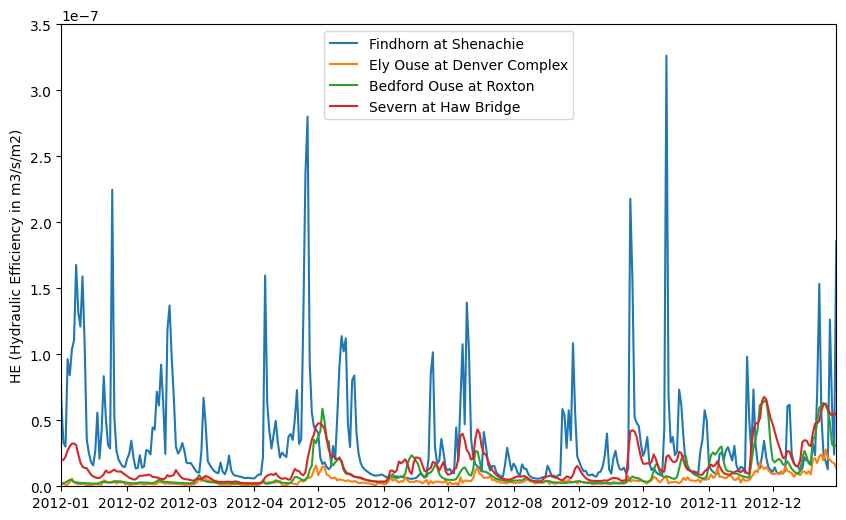

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for station in ['7001', '33035', '33039', '54057']:
    
    year = 2012
    boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
    area = boundary.geometry.area
    
    df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    
    filename = paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_lumped.csv')
    rf = pd.read_csv(filename)
    rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
    rf = rf.dropna(subset=['Flow'])
    
    rf['NE'] = rf['Flow'].apply(lambda flow: flow/area)
    
    plt.plot(rf['Date'], rf['NE'], label=name) #Temperature, Rain, ...
    plt.ylabel('HE (Hydraulic Efficiency in m3/s/m2)')
    #plt.ylabel('Rain')
    plt.xlim([datetime.date(year, 1, 1), datetime.date(year, 12, 31)])
    plt.ylim(0,0.00000035)
      
plt.legend()
plt.show()

Mean  113.01424824720851
Deviation  115.18443115966095
Maximum  1340.0


<Axes: >

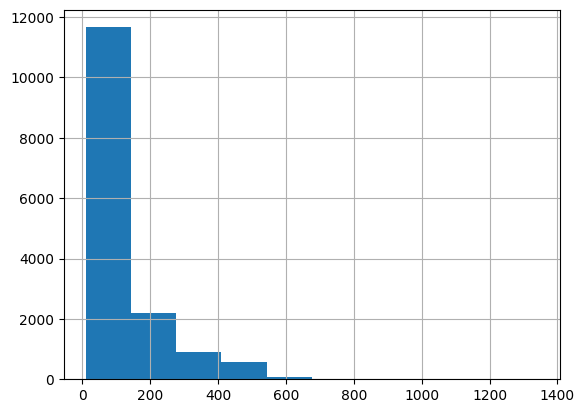

In [12]:
print('Mean ', rf['Flow'].mean())
print('Deviation ', rf['Flow'].std())
print('Maximum ', rf['Flow'].max())

rf['Flow'].hist()

### 2. Streamflow Training/Prediction

In [99]:
### Identify features (with either antecedent proxies or soil moisture levels)
days = 6
hours = 24
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
            + ['Snow Melt'] + ['Snow Melt-' + f'{d+1}' for d in range(days)] 
            + ['Temperature'] \
            + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] \
            + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)]\
            + ['Soil Moisture ' + f'{i+1}' for i in range(4)])
            #+ ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']) 
    
                
'''     
    
        #      + [f"Rain_-{i+1}" for i in range(hours)]
            #+ ['Soil Moisture ' + f'{i+1}' for i in range(4)])
        + [f"Rain_{i}+1" for i in range(1,10)])
         + [f'Rain_{i//2}_2hourly' for i in range(0, 24, 2)]
            
            + ['Rain_2h_mean', 'Rain_4h_mean', 'Rain_6h_mean'])
             ['Delta_x'] + ['Delta_y'])
            + ['Rain_' + f'{d}' for d in range(hours)] \
            #
            #+ ['Delta_y-1'] + ['Delta_x-1'])
            #"
            '''
print(features)
print(len(features))

['Rain', 'Rain-1', 'Rain-2', 'Rain-3', 'Rain-4', 'Rain-5', 'Rain-6', 'Snow Melt', 'Snow Melt-1', 'Snow Melt-2', 'Snow Melt-3', 'Snow Melt-4', 'Snow Melt-5', 'Snow Melt-6', 'Temperature', 'Temperature-1', 'Temperature-2', 'Temperature-3', 'Temperature-4', 'Temperature-5', 'Temperature-6', 'Resultant Windspeed', 'Resultant Windspeed-1', 'Resultant Windspeed-2', 'Resultant Windspeed-3', 'Resultant Windspeed-4', 'Resultant Windspeed-5', 'Resultant Windspeed-6', 'Humidity', 'Humidity-1', 'Humidity-2', 'Humidity-3', 'Humidity-4', 'Humidity-5', 'Humidity-6', 'Soil Moisture 1', 'Soil Moisture 2', 'Soil Moisture 3', 'Soil Moisture 4']
39


In [100]:
import importlib
importlib.reload(load_data)
importlib.reload(train)

<module 'train_model.train' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\train.py'>

In [101]:
def full_training_loop(rf, features=features, loss_func=None, alpha=1.0, beta=1.0, grid_search=False, verbose=True):

    years_eval = [2010 + i for i in range(12)]
    #years_train = [1982,1983, 1991,1993,1997,2000]

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf, features, years_eval)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    # TRAINING
    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)   
    
    psi = ut.psi_distribution(y_train, 'lognorm', alpha=alpha, beta=beta, plot=verbose)
    
    network = train.train(x_train, 
                          y_train,
                          verbose=verbose, 
                          loss_func_type=loss_func, 
                          psi=psi[:len(x_train)], 
                          grid_search=grid_search)

    # EVALUATION
    x_test = load_data.reshape_input(full_set, xspace)  
    y_test = load_data.reshape_input(full_set, yspace)  
    x_test = torch.from_numpy(x_test).to(device)
    rf['Predicted'] = network.predict(x_test)

    if rf['Date'].dtype == 'float64':
        rf['Date'] = pd.to_datetime(rf['Date'], unit='s').dt.date
    testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
    return testrf, rf, network, y_test

#### 2a. Application to one site

In [102]:
importlib.reload(load_data)
importlib.reload(train)

<module 'train_model.train' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\train.py'>

Processing site " Findhorn at Shenachie "


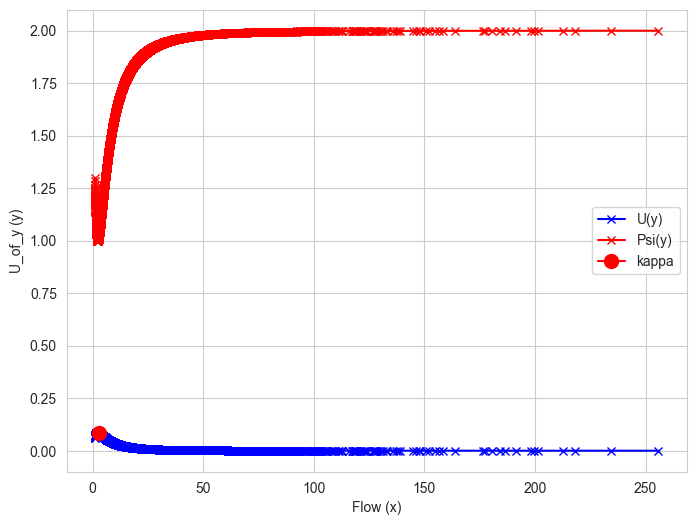

epoch 0, loss 592.5040283203125
epoch 500, loss 121.53323364257812
epoch 1000, loss 100.46238708496094
epoch 1500, loss 88.27691650390625
epoch 2000, loss 77.5362548828125
epoch 2500, loss 70.72079467773438
epoch 3000, loss 68.20938873291016
epoch 3500, loss 67.21817016601562
epoch 4000, loss 66.83070373535156
Early stopping at epoch 4023, best validation loss: 79.59288024902344


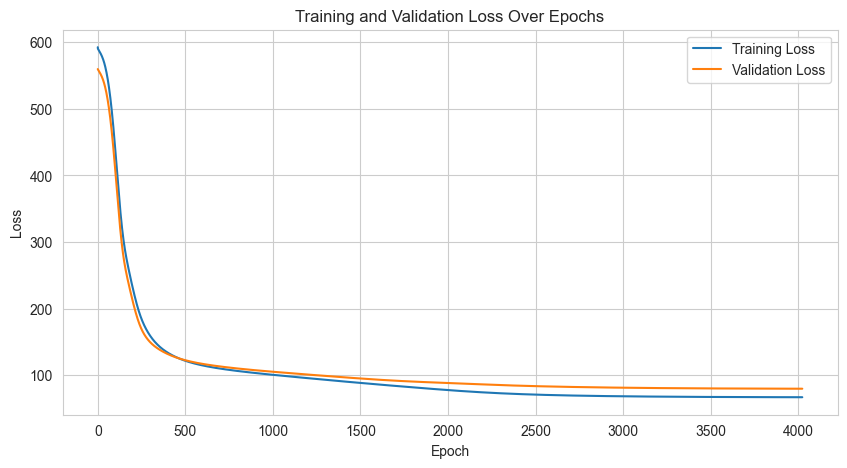

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


In [103]:
station_nr = 7001
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
name = df.loc[df.index[3]].iloc[2]
print('Processing site "', name, '"')
    
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)

# HOURLY INPUT
hourly_df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + f"/{station_nr}_daily_rain_9to9_linear.csv")
hourly_df = hourly_df.rename(columns={'date': 'Date'})
hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date
hourly_df = hourly_df.drop(rf.index[:365])

# 2-HOURLY INPUT
for i in range(1, 25, 2):
    col_name = f'Rain_{i//2}_2hourly'
    hourly_df[col_name] = hourly_df[f"Rain_-{i}"] + hourly_df[f"Rain_-{i+1}"]

'''
# ROLLING MEANS OVER TIME WINDOWS
hourly_df['Rain_2h_mean'] = hourly_df.rolling(window=2, axis=1).mean().iloc[1:, -1]
hourly_df['Rain_4h_mean'] = hourly_df.rolling(window=4, axis=1).mean().iloc[1:, -1]
hourly_df['Rain_6h_mean'] = hourly_df.rolling(window=6, axis=1).mean().iloc[1:, -1]

# PARAMETRISATION
hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_{i}" for i in range(24)]].sum()/24), axis=1)
hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)

# 9 HOURS FOR NEXT DAY (9am - 9am flow monitoring)
for variable in [f"Rain_{i}" for i in range(10)]:
    i = 1
    hourly_df[str(variable) + '+{0}'.format(i)] = hourly_df[variable].shift(-i)
    
# 24 HOURS PREVIOUS DAY
for variable in [f"Rain_{i}" for i in range(24)]:
    i = 1
    hourly_df[str(variable) + '-{0}'.format(i)] = hourly_df[variable].shift(-i)

'''
combined_rf = pd.merge(rf, hourly_df, on='Date')
combined_rf = combined_rf.dropna()

testrf_predicted, rf_predicted, network, y_test = full_training_loop(combined_rf, features=features, loss_func=None, alpha=1, beta=2, grid_search=False) 
# loss_func ='Reflective'

2921


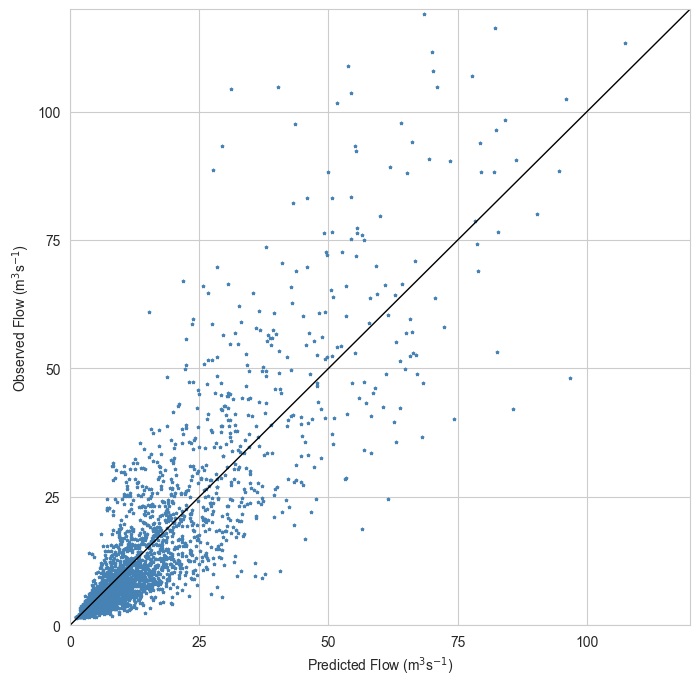

- - - - - - - - - - - - - - -
RMSE: 9.473091107858037
NSE: 0.7614719167916671
RE: 0.9350121776717907
12418


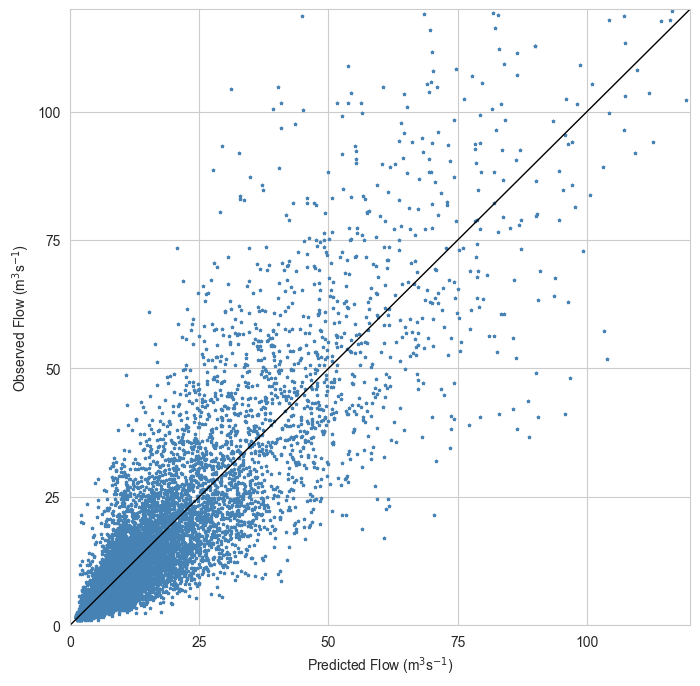

- - - - - - - - - - - - - - -
RMSE: 8.612110263732573
NSE: 0.7970943731531941
RE: 0.933535177708739


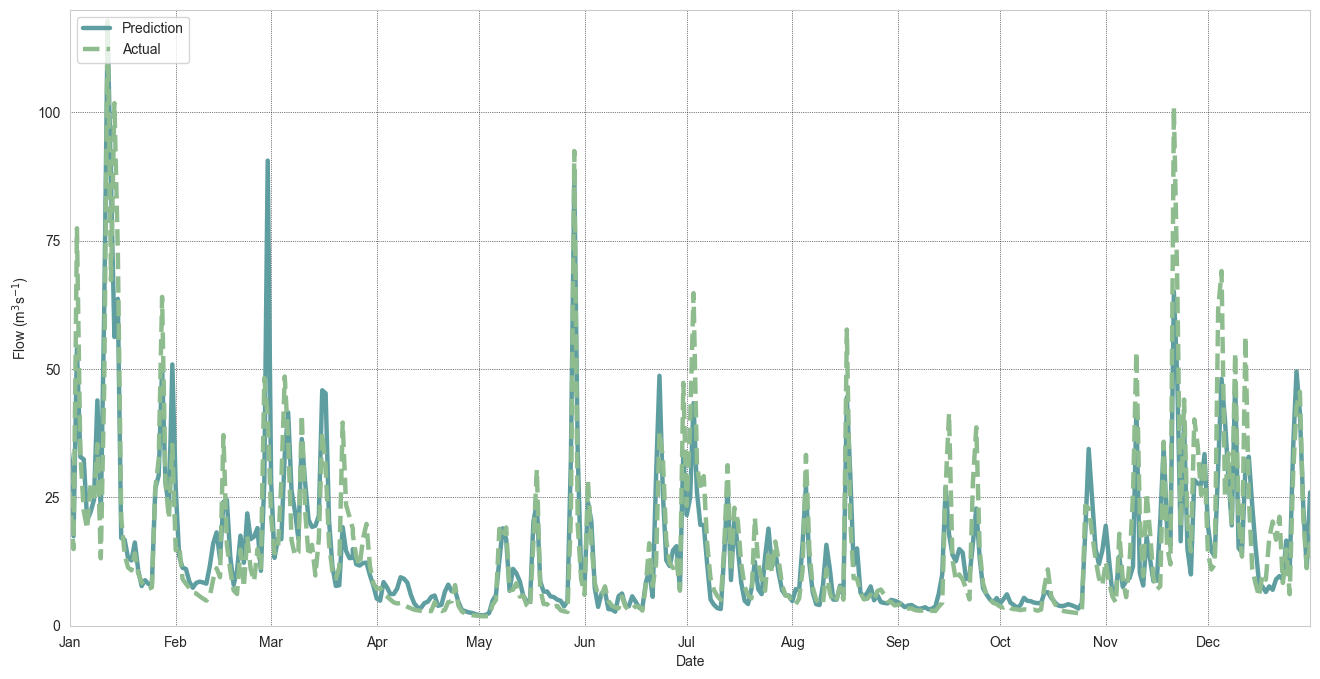

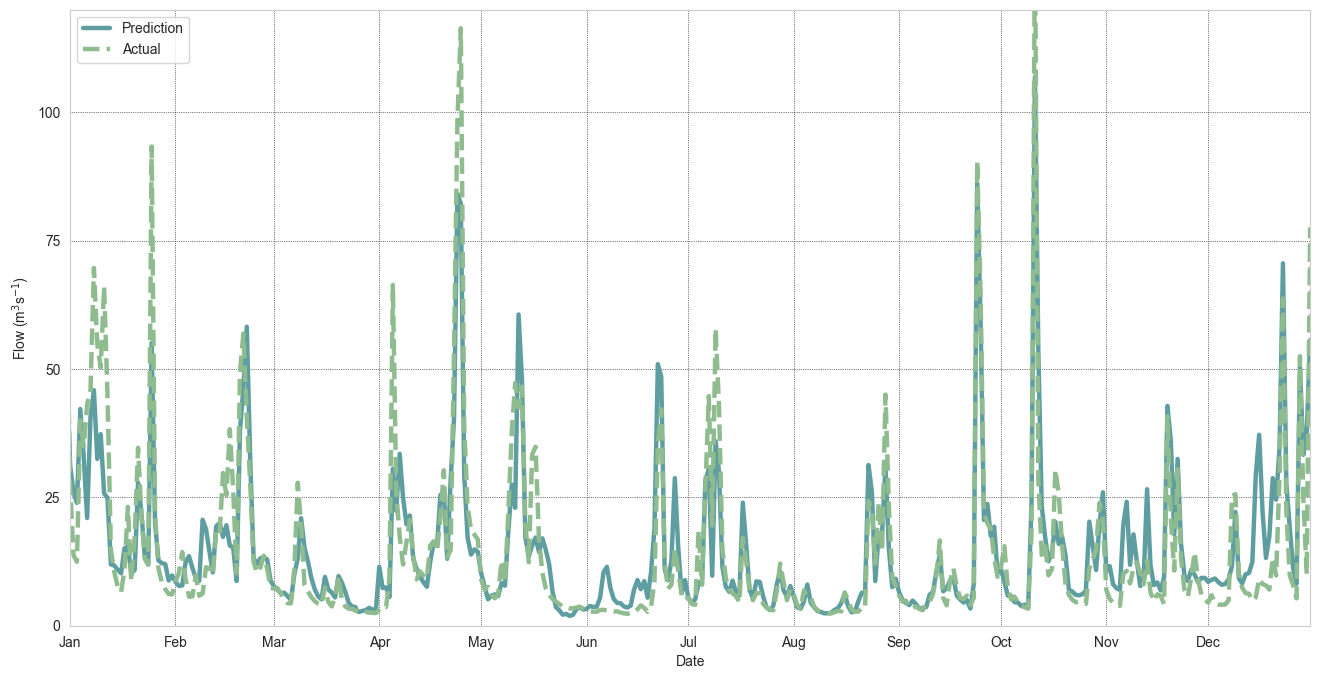

In [104]:
maxflow = 120

# recalculate PSI for alpha=1 and beta=1
psi_RE = ut.psi_distribution(y_test, 'lognorm')

for df in (testrf_predicted, rf_predicted):
    
    df = df.iloc[:-1]
    psi_df = psi_RE[-len(df):].squeeze()
    print(len(psi_df))

    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
strf.year_plot(maxflow, rf_predicted, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, rf_predicted, 'Predicted', 'Flow', 2012)  

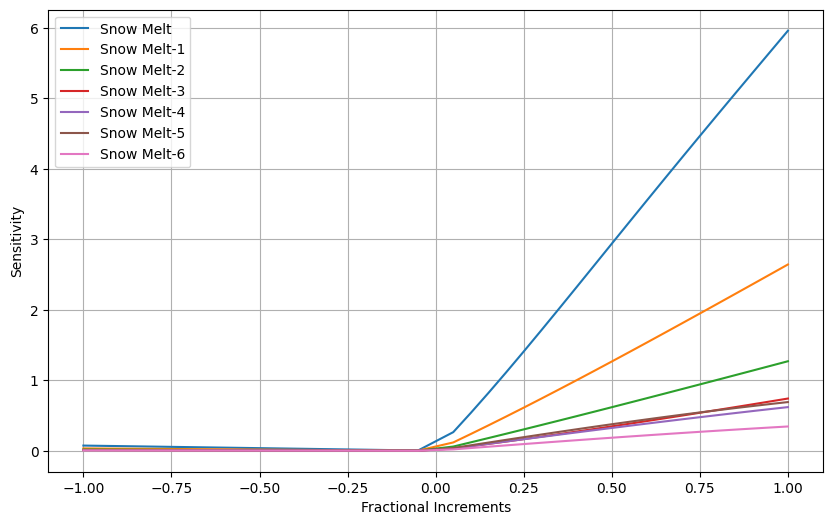

In [53]:
names = ['Rain', 'Temperature', 'Resultant Windspeed', 'Humidity']
names_rain = ['Rain'] + [f"Rain-{i}" for i in range(1,7)]
names_snow = ['Snow Melt'] + [f"Snow Melt-{i}" for i in range(1,7)]
names_temperature = ['Temperature'] + [f"Temperature-{i}" for i in range(1,7)]
names_windspeed = ['Resultant Windspeed'] + [f"Resultant Windspeed-{i}" for i in range(1,7)]
names_humidity = ['Humidity'] + [f"Humidity-{i}" for i in range(1,7)]
names_proxies = ['Rain_28_Mu', 'Rain_90_Mu', 'Rain_180_Mu', 
                 'Temperature_28_Mu', 'Temperature_90_Mu', 'Temperature_180_Mu']
names_proxies_temp = ['Temperature_28_Mu', 'Temperature_90_Mu', 'Temperature_180_Mu']
names_proxies_prec = ['Rain_28_Mu', 'Rain_90_Mu', 'Rain_180_Mu']
names_soil_moisture =  ['Soil Moisture ' + f'{i+1}' for i in range(4)]
names_hourly_rain = [f"Rain_{i}" for i in range(0,24)]
names_2hourly_rain = [f'Rain_{i//2}_2hourly' for i in range(0, 24, 2)]
names_rain_params = ['Delta_x', 'Delta_y']
names_next_day_rain = [f"Rain_{i}+1" for i in range(1,10)]
names_prev_day_rain = [f"Rain_{i}-1" for i in range(12, 24)]
names_rain_various_means = ['Rain_2h_mean', 'Rain_4h_mean', 'Rain_6h_mean']

names_custom = [f"Rain_{i}" for i in range(9,24)] + [f"Rain_{i}+1" for i in range(1,10)]

sf = sa.perform_sensitivity_analysis(network, features, rf_predicted, names_snow)
sa.plot_sensitivities(sf, names_snow)

In [105]:
rf_predicted['error'] = rf_predicted['Predicted'] - rf_predicted['Flow']
rf_predicted['MAPE'] = (rf_predicted['Predicted'] - rf_predicted['Flow'])/rf_predicted['Predicted']

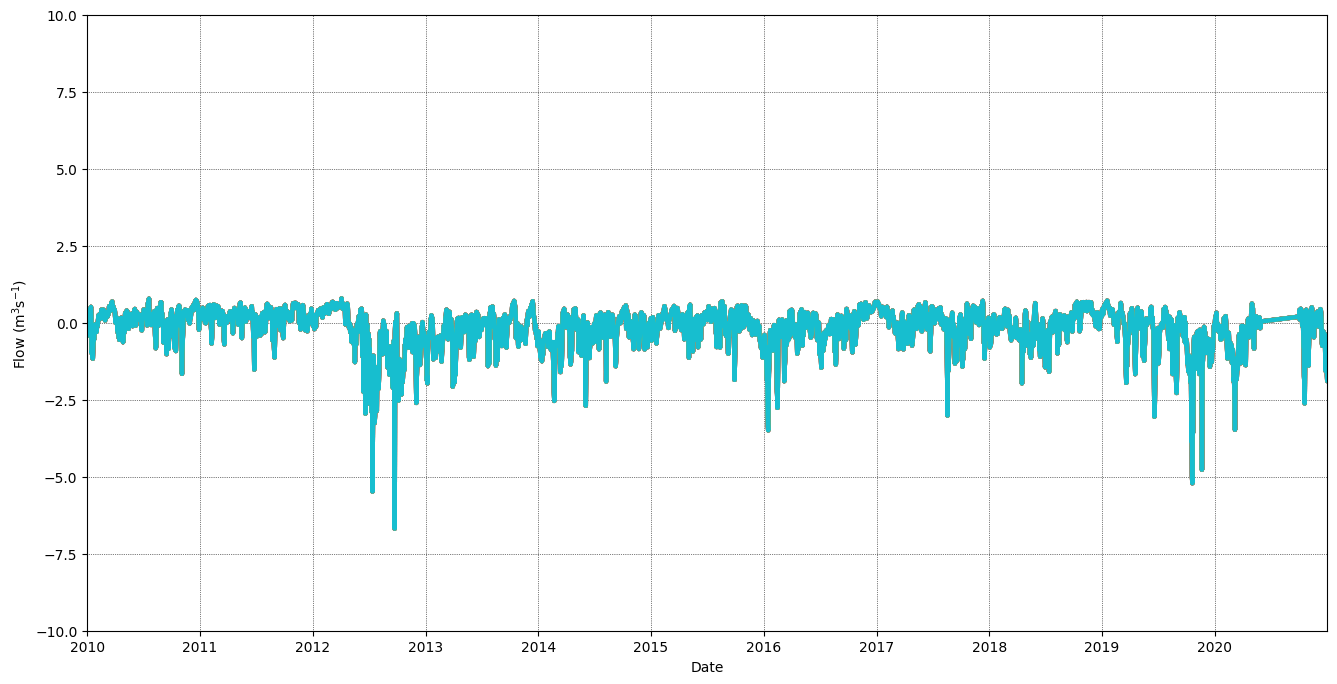

In [106]:
import datetime as dt

year = 2012

fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Date')
ax.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')

year1 = 2010
year2 = 2020

for year in range(year1,year2):
    
    #df_select = df[pd.to_datetime(df['Date']).dt.year.isin([str(year)])]
    #print(df_select)
    
    ax.plot(rf_predicted['Date'], rf_predicted['MAPE'], lw=3.2)

ax.set_xlim([dt.date(year1, 1, 1), dt.date(year2, 12, 31)])
ax.set_ylim(-10,10)

ax.grid(c='black', ls='dotted', lw=0.5)
plt.show()

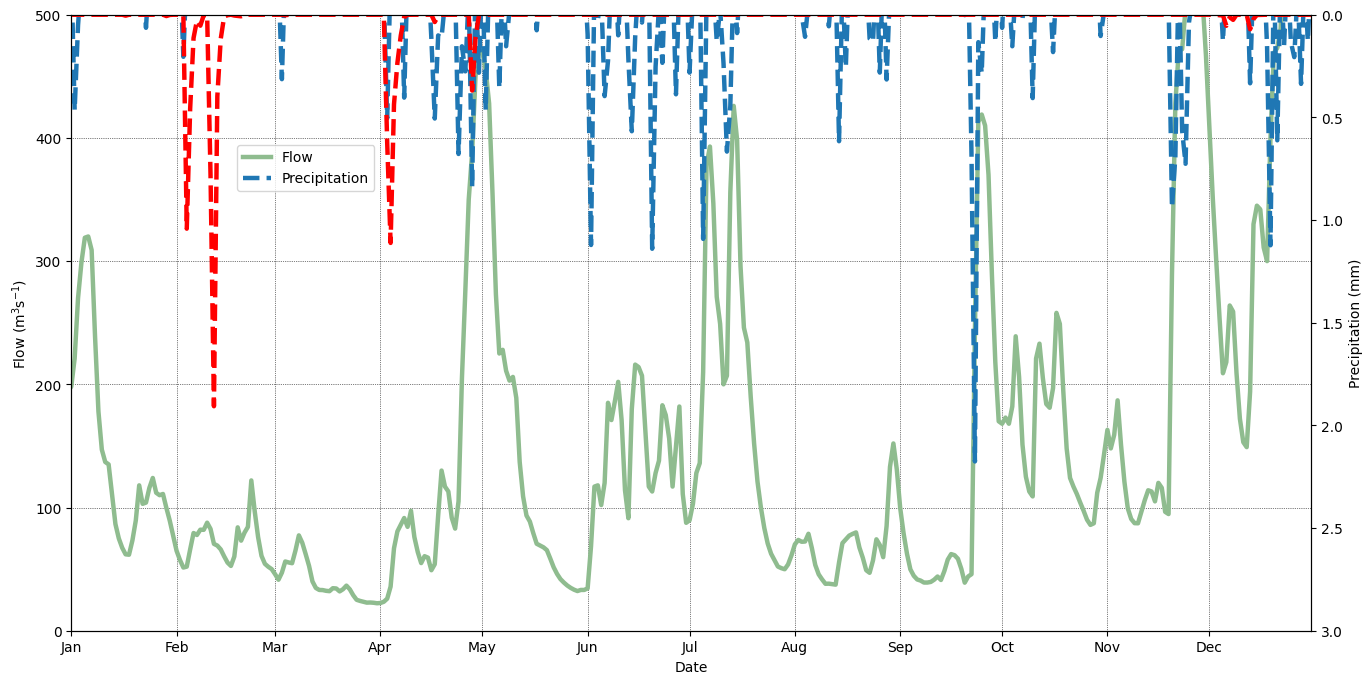

In [109]:
import matplotlib.dates as mdt
import matplotlib.ticker as mtk
import matplotlib.pyplot as plt
import numpy as np

def hydroVrain(maxflow, maxrain, xf, flow, rain, year, colour1='cadetblue',

               colour2='darkseagreen', maxsnow=None, snow=None):

    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])

    ax1.set_xlabel('Date')

    ax1.xaxis.set_major_locator(mdt.MonthLocator())

    ax1.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

    ax1.set_ylim(0,maxflow)

    ax1.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')

    ax1.yaxis.set_major_locator(mtk.MaxNLocator(5))

    ax1.grid(c='black', ls='dotted', lw=0.5)

    ax1.plot(xf['Date'], xf[flow], colour2, lw=3.2, label='Flow')

    ax1.plot(np.nan, colour1, lw=3.2, label='Precipitation', ls='--')

    ax2 = ax1.twinx()

    ax2.set_ylabel('Precipitation (mm)')

    ax2.set_ylim(maxrain,0)

    ax2.plot(xf['Date'], xf[rain], colour1, lw=3.2, ls='--')
    
    if snow is not None:
        ax2.plot(xf['Date'], xf[snow], 'red', lw=3.2, ls='--')

    ax1.legend(loc=0, bbox_to_anchor=(0.25,0.8))

    plt.show()
    
hydroVrain(500, 3, rf, 'Flow', 'Rain', 2012, 15, snow='Snow Melt')

In [135]:
network

NeuralNetworkRegressor(dropout_rate=0.2, input_size=38, learning_rate=0.005,
                       weight_decay=0.01)

In [34]:
overview = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)[['Date', 'Flow']]

overview['Psi'] = psi_RE

# compare with 
pd.read_csv(paths.CATCHMENT_BASINS + '/45009/ReflectiveError_Pixton.csv')

ValueError: Length of values (15341) does not match length of index (15527)

#### 2b. Application on all the sites together

In [163]:
results_gdf = gp.GeoDataFrame(columns=['Station', 'Name', 'NSE', 'HE_mean', 'HE_std', 'Geometry'])
sf_summary = pd.DataFrame({'Variable': names_rain})

for station_nr in os.listdir(paths.CATCHMENT_BASINS):
    
    df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    print('Processing site "', name, '"')
    
    boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
    rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)
    
    hourly_df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + f"/{station_nr}_daily_rain.csv")
    hourly_df = hourly_df.rename(columns={'date': 'Date'})
    hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date
    hourly_df = hourly_df.drop(rf.index[:365])
    
    # 2-HOURLY INPUT
    for i in range(0, 24, 2):
        col_name = f'Rain_{i//2}_2hourly'
        hourly_df[col_name] = hourly_df[f"Rain_{i}"] + hourly_df[f"Rain_{i+1}"]


    hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_{i}" for i in range(24)]].sum()/24), axis=1)
    hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)

    combined_rf = pd.merge(rf, hourly_df, on='Date')
    
    testrf, rf_predicted, network, _ = full_training_loop(combined_rf, verbose=False)
 
    # Calculate the NSE
    NSE = me.R2(testrf['Flow'], testrf['Predicted'])
    
    # Calculate the hydraulic efficiency
    HE_mean = (rf_predicted['Flow'].mean()/boundary.geometry.area)*(10^6)
    HE_std = (rf_predicted['Flow'].std()/boundary.geometry.area)*(10^6)

    # Assuming 'results_gdf' is your existing GeoDataFrame
    new_data = gp.GeoDataFrame({
        'Station': station_nr,
        'Name': name, 
        'NSE': NSE,
        'HE_mean': HE_mean,
        'HE_std': HE_std, 
        'Geometry': boundary.geometry.iloc[0]
    })

    results_gdf = pd.concat([results_gdf, new_data], ignore_index=True)
    
    sf = sa.perform_sensitivity_analysis(network, features, rf_predicted, names_proxies)
    sf_summary[f"{station_nr}_+0.5"] = sf["+0.5"]
    sf_summary[f"{station_nr}_+1.0"] = sf["+1.0"]
    
results_gdf    

Processing site " Dee at Polhollick "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
C:\Users\aline\AppData\Local\Temp\ipykernel_16992\1655411160.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_gdf = pd.concat([results_gdf, new_data], ignore_index=True)


Processing site " Devon at Glenochil "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Coquet at Morwick "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Ure at Westwick "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Swale at Crakehill "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Derwent at Malton A64 Road Bridge "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Trent at North Muskham "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Derwent at Church Wilne "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Derwent at St Mary's Bridge "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Ely Ouse at Denver Complex "
using a different normalizer


C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:6556: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aline\soil-moisture-proxies\apollo\metrics.py:119: RuntimeWarning: divide by zero encountered in divide
  return -1 * alpha * (u_of_y/kappa) + beta
C:\Users\aline\soil-moisture-proxies\apollo\metrics.py:119: RuntimeWarning: invalid value encountered in divide
  return -1 * alpha * (u_of_y/kappa) + beta
C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor

Processing site " Bedford Ouse at Roxton "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Wensum at Costessey Mill "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Thames at Eynsham "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Kennet at Theale "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Thames at Royal Windsor Park "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Exe at Pixton "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Glass at Kerrow Wood "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Glass at Fasnakyle "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Avon at Bathford "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Teme at Tenbury "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Severn at Haw Bridge "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Findhorn at Shenachie "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Wyre at Scorton Weir "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Spey at Kinrara "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Bogie at Redcraig "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Broom at Inverbroom "
using a different normalizer


C:\Users\aline\soil-moisture-proxies\train_model\train.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Station                               Name       NSE       HE_mean  \
0    12003                  Dee at Polhollick  0.663545  4.087865e-07   
1    18002                 Devon at Glenochil  0.510232  3.499524e-07   
2    22001                  Coquet at Morwick  0.635728  1.840470e-07   
3    27007                    Ure at Westwick  0.676811  3.035609e-07   
4    27071                 Swale at Crakehill  0.590031  1.844442e-07   
5    27099  Derwent at Malton A64 Road Bridge  0.705279  1.416165e-07   
6    28022             Trent at North Muskham  0.669169  1.334391e-07   
7    28067            Derwent at Church Wilne  0.635027  1.955294e-07   
8    28085        Derwent at St Mary's Bridge  0.706087  2.000281e-07   
9    33035         Ely Ouse at Denver Complex  0.678662  5.134962e-08   
10   33039             Bedford Ouse at Roxton  0.642984  8.541051e-08   
11   34004           Wensum at Costessey Mill  0.693855  8.927057e-08   
12   39008                  Thames at Eynsham  0.840059  1.071058e-07   
13   39016                   Kennet at Theale  0.829025  1.134138e-07   
14   39072       Thames at Royal Windsor Park  0.789402  1.003102e-07   
15   45009                      Exe at Pixton  0.637371  3.761826e-07   
16    5003               Glass at Kerrow Wood  0.683772  7.663366e-07   
17    5004                 Glass at Fasnakyle  0.492988  2.097820e-07   
18   53018                   Avon at Bathford  0.710033  1.511739e-07   
19   54008                    Teme at Tenbury  0.698590  1.611779e-07   
20   54057               Severn at Haw Bridge  0.691156  1.376377e-07   
21    7001              Findhorn at Shenachie  0.634508  4.245419e-07   
22   72016               Wyre at Scorton Weir  0.631141  4.456885e-07   
23    8002                    Spey at Kinrara  0.657944  2.963918e-07   
24    9004                  Bogie at Redcraig  0.549494  2.105348e-07   
25   95002                Broom at Inverbroom  0.743751  6.141976e-07   

          HE_std                                           Geometry  
0   4.171695e-07  POLYGON ((334425.00009999983 796575.0000999998...  
1   4.353710e-07  POLYGON ((285800.00009999983 696025.0000999998...  
2   2.878931e-07  POLYGON ((423475.00009999983 604450.0000999998...  
3   4.147252e-07  POLYGON ((435600.00009999983 467025.0000999998...  
4   2.142350e-07  POLYGON ((442525.00009999983 473300.0000999998...  
5   1.200397e-07  POLYGON ((481175.00009999983 473075.0000999998...  
6   1.137156e-07  POLYGON ((480475.00009999983 360525.0000999998...  
7   2.001477e-07  POLYGON ((444175.00009999983 331650.0000999998...  
8   1.968036e-07  POLYGON ((435350.00009999983 336875.0000999998...  
9   4.720514e-08  POLYGON ((558925.0000999998 300975.00009999983...  
10  1.005629e-07  POLYGON ((516025.00009999983 253525.0000999998...  
11  6.258273e-08  POLYGON ((617650.0000999998 312775.00009999983...  
12  1.151196e-07  POLYGON ((444525.00009999983 208700.0000999998...  
13  7.251435e-08  POLYGON ((464975.00009999983 170850.0000999998...  
14  8.890378e-08  POLYGON ((498075 177200, 498075 177150, 497975...  
15  4.310974e-07  POLYGON ((293525.00009999983 125975.0000999998...  
16  5.649712e-07  POLYGON ((235475.00009999983 832100.0000999998...  
17  3.315644e-07  POLYGON ((231575.00009999983 828750.0000999998...  
18  1.901734e-07  POLYGON ((378525.00009999983 167025.0000999998...  
19  2.064913e-07  POLYGON ((359775.00009999983 268500.0000999998...  
20  1.399324e-07  POLYGON ((384500.00009999983 227875.0000999998...  
21  5.432463e-07  POLYGON ((282575.00009999983 833550.0000999998...  
22  7.039120e-07  POLYGON ((350075.00009999983 449975.0000999998...  
23  2.977669e-07  POLYGON ((288125.00009999983 808225.0000999998...  
24  1.883827e-07  POLYGON ((351950.00009999983 837475.0000999998...  
25  8.785551e-07  POLYGON ((218400.00009999983 884225.0000999998...

In [173]:
proxies = ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']

sf_summary = sf_summary[:-1]
sf_summary['Variable'] = proxies
sf_summary

Variable  12003_+0.5  12003_+1.0  18002_+0.5  18002_+1.0  \
0          Rain_28_Mu    1.513791    3.097095    0.733885    1.577664   
1          Rain_90_Mu    0.340195    0.438536    0.236677    0.483151   
2         Rain_180_Mu    0.179418    0.341981    0.141034    0.304311   
3   Temperature_28_Mu    0.349451    0.179771    0.343286    0.617711   
4   Temperature_90_Mu    0.212920    0.040053    0.208138    0.387700   
5  Temperature_180_Mu    0.129181    0.495784    0.320514    0.672757   

   22001_+0.5  22001_+1.0  27007_+0.5  27007_+1.0  27071_+0.5  ...  7001_+0.5  \
0    3.011371    5.305228    1.036491    1.941333    1.180484  ...   0.725395   
1    0.367685    0.473884    0.174974    0.280676    0.130739  ...   0.064853   
2    0.380435    0.757620    0.223404    0.398356    0.247279  ...   0.178611   
3    0.617570    0.750798    0.329080    0.504937    0.385930  ...   0.380367   
4    0.369877    0.475045    0.411256    0.695626    0.508701  ...   0.322530   
5    0.578227    0.978223    0.406995    0.820743    0.459116  ...   0.224898   

   7001_+1.0  72016_+0.5  72016_+1.0  8002_+0.5  8002_+1.0  9004_+0.5  \
0   0.947505    0.493163    1.024480   1.671684   3.731715   0.733624   
1   0.002391    0.144572    0.276245   0.276474   0.561835   0.164901   
2   0.302244    0.067521    0.153058   0.290228   0.574879   0.315234   
3   0.228195    0.306704    0.556768   0.252590   0.091395   0.266436   
4   0.794088    0.124906    0.280005   0.297123   0.194207   0.078966   
5   0.343822    0.084979    0.203359   0.361642   0.952828   0.057572   

   9004_+1.0  95002_+0.5  95002_+1.0  
0   1.848397    0.805923    1.610713  
1   0.323926    0.107154    0.224836  
2   0.680671    0.004260    0.022247  
3   0.495408    0.066568    0.068419  
4   0.151071    0.078096    0.116389  
5   0.112720    0.145129    0.299075  

[6 rows x 53 columns]

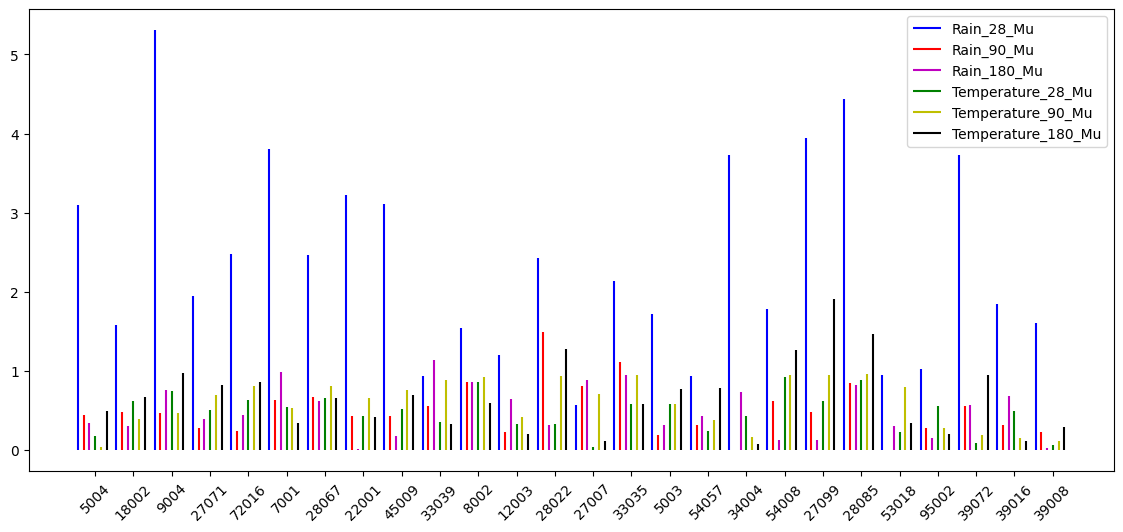

In [176]:
def retrieve_sensitivity(sf_summary, station_nr, sensitivity_degree, feature):
    
    sf_feature = sf_summary[sf_summary['Variable'] == feature]
    return sf_feature.loc[sf_feature.index[0], f"{station_nr}_+{sensitivity_degree}"]

#retrieve_sensitivity(sf_summary, 12003, 0.5, 'Rain')

sorted_results = results_gdf.sort_values(by='NSE')

plt.figure(figsize=(14, 6))

feature = 'Rain-1'
bar_width = 0.15
station_labels = sorted_results['Station'].unique()

features = ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
colors = ['b', 'r', 'm', 'g', 'y', 'k']

labels_added = {feature: False for feature in features}

# Plot vertical lines for each feature
for index, row in sorted_results.iterrows():
    for i, feature in enumerate(features):
        color = colors[i]
        x_offset = (i - 3) * bar_width  # Adjust the x position to avoid overlap
        
        # Only add the label once
        label = feature if not labels_added[feature] else ""
        labels_added[feature] = True

        plt.vlines(x=index + x_offset, ymin=0, ymax=retrieve_sensitivity(sf_summary, row['Station'], sensitivity_degree=1.0, feature=feature), colors=color, linestyles='solid', label=label)
    
plt.xticks(ticks=range(len(station_labels)), labels=station_labels, rotation=45)
plt.legend()
plt.show()

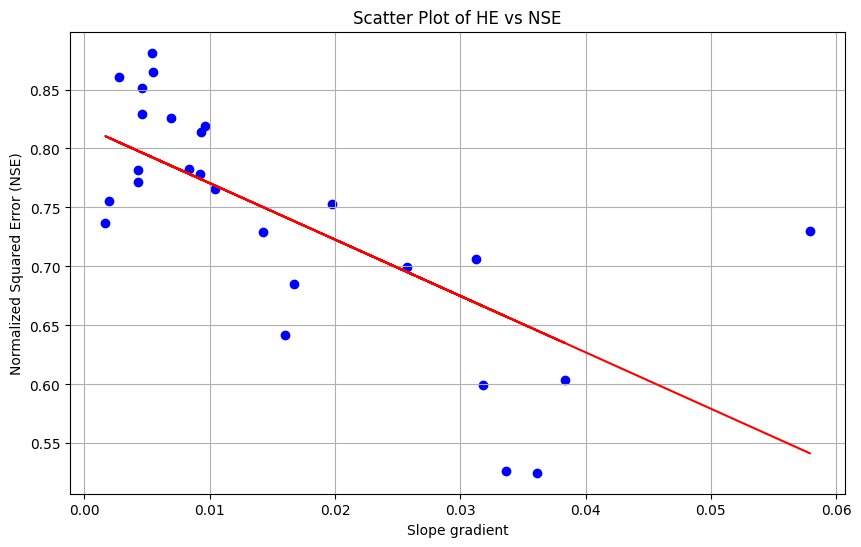

In [25]:
import matplotlib.pyplot as plt

param_to_plot= 'Slope gradient'#'HE_mean'

plt.figure(figsize=(10, 6))

# Scatter plot for the mean values
plt.scatter(results_gdf[param_to_plot], results_gdf['NSE'], color='blue', marker='o')

# Error bars for the standard deviation
#plt.errorbar(results_gdf['HE_mean'], results_gdf['NSE'], xerr=results_gdf['HE_std'], fmt='o', color='blue', capsize=5)

# Adding labels and title
plt.xlabel(f"{param_to_plot}")
plt.ylabel('Normalized Squared Error (NSE)')
plt.title('Scatter Plot of HE vs NSE')

# Optional: Adding a line of best fit to help visualize any linear trend
import numpy as np
m, b = np.polyfit(results_gdf[param_to_plot], results_gdf['NSE'], 1)
plt.plot(results_gdf[param_to_plot], m*results_gdf[param_to_plot] + b, color='red')  # Line of best fit

plt.grid(True)
plt.show()

In [340]:
from shapely import Point

def find_longest_diagonal(polygon):
    box = polygon.minimum_rotated_rectangle
    x, y = box.exterior.coords.xy

    # get length of bounding box edges
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_length)

results_gdf['Cross_distance'] = results_gdf['Geometry'].apply(lambda geometry: find_longest_diagonal(geometry)) 
results_gdf['Area']= results_gdf['Geometry'].apply(lambda geometry: geometry.area)

In [341]:
metadata = pd.read_csv(paths.DATA + '/Catchments_Fens.csv')

results_gdf['Minimum altitude'] = results_gdf['Station'].apply(lambda station: metadata[metadata['Station number'] == int(station)]['Minimum altitude'].iloc[0])
results_gdf['Maximum altitude'] = results_gdf['Station'].apply(lambda station: metadata[metadata['Station number'] == int(station)]['Maximum altitude'].iloc[0])
results_gdf['Height difference'] = results_gdf['Maximum altitude'] - results_gdf['Minimum altitude']
results_gdf['Slope gradient'] = results_gdf['Height difference']/results_gdf['Cross_distance']

In [103]:
results_gdf

Station                               Name       NSE       HE_mean  \
0    12003                  Dee at Polhollick  0.700921  4.077777e-07   
1    18002                 Devon at Glenochil  0.600896  3.501415e-07   
2    22001                  Coquet at Morwick  0.691732  1.836751e-07   
3    27071                 Swale at Crakehill  0.771391  1.852439e-07   
4    27099  Derwent at Malton A64 Road Bridge  0.827494  1.416165e-07   
5    28067            Derwent at Church Wilne  0.777807  1.950332e-07   
6    28085        Derwent at St Mary's Bridge  0.806515  1.994347e-07   
7    33035         Ely Ouse at Denver Complex  0.735408  5.113488e-08   
8    33039             Bedford Ouse at Roxton  0.778438  8.513027e-08   
9    34004           Wensum at Costessey Mill  0.753925  8.911289e-08   
10   39008                  Thames at Eynsham  0.882008  1.064532e-07   
11   39016                   Kennet at Theale  0.783379  1.129218e-07   
12   45009                      Exe at Pixton  0.728403  3.757230e-07   
13    5003               Glass at Kerrow Wood  0.705217  7.663366e-07   
14    5004                 Glass at Fasnakyle  0.524716  2.097820e-07   
15   53018                   Avon at Bathford  0.826325  1.505048e-07   
16   54008                    Teme at Tenbury  0.817005  1.602878e-07   
17   54057               Severn at Haw Bridge  0.851666  1.371884e-07   
18    7001              Findhorn at Shenachie  0.654558  4.234142e-07   
19   72016               Wyre at Scorton Weir  0.606031  4.474353e-07   
20    8002                    Spey at Kinrara  0.751145  2.956321e-07   
21    9004                  Bogie at Redcraig  0.524619  2.105348e-07   
22   95002                Broom at Inverbroom  0.722616  6.141976e-07   

          HE_std                                           Geometry  \
0   4.156071e-07  POLYGON ((334425.00009999983 796575.0000999998...   
1   4.354216e-07  POLYGON ((285800.00009999983 696025.0000999998...   
2   2.869327e-07  POLYGON ((423475.00009999983 604450.0000999998...   
3   2.148020e-07  POLYGON ((442525.00009999983 473300.0000999998...   
4   1.200397e-07  POLYGON ((481175.00009999983 473075.0000999998...   
5   1.997474e-07  POLYGON ((444175.00009999983 331650.0000999998...   
6   1.966020e-07  POLYGON ((435350.00009999983 336875.0000999998...   
7   4.705311e-08  POLYGON ((558925.0000999998 300975.00009999983...   
8   1.008762e-07  POLYGON ((516025.00009999983 253525.0000999998...   
9   6.251573e-08  POLYGON ((617650.0000999998 312775.00009999983...   
10  1.150044e-07  POLYGON ((444525.00009999983 208700.0000999998...   
11  7.233785e-08  POLYGON ((464975.00009999983 170850.0000999998...   
12  4.307143e-07  POLYGON ((293525.00009999983 125975.0000999998...   
13  5.649712e-07  POLYGON ((235475.00009999983 832100.0000999998...   
14  3.315644e-07  POLYGON ((231575.00009999983 828750.0000999998...   
15  1.903644e-07  POLYGON ((378525.00009999983 167025.0000999998...   
16  2.066249e-07  POLYGON ((359775.00009999983 268500.0000999998...   
17  1.398227e-07  POLYGON ((384500.00009999983 227875.0000999998...   
18  5.415733e-07  POLYGON ((282575.00009999983 833550.0000999998...   
19  7.040821e-07  POLYGON ((350075.00009999983 449975.0000999998...   
20  2.965888e-07  POLYGON ((288125.00009999983 808225.0000999998...   
21  1.883827e-07  POLYGON ((351950.00009999983 837475.0000999998...   
22  8.785551e-07  POLYGON ((218400.00009999983 884225.0000999998...   

            Area  Cross_distance  Minimum altitude  Maximum altitude  \
0   6.975003e+08    42293.346798             219.6            1308.9   
1   1.786850e+08    22491.447241               4.4             720.5   
2   5.782494e+08    45951.263162               5.2             774.5   
3   1.354417e+09    75623.598152              14.6             714.3   
4   1.382881e+09    63654.751743              15.2             453.2   
5   1.176617e+09    72209.835522              30.7             635.5   
6   1.051008e+09    63617.961501         

In [128]:
# Assuming 'results_gdf' is your GeoDataFrame with 'HE', 'NSE', and 'Station' columns
fig = px.scatter(results_gdf, x='HE_mean', y='NSE', text='Station', 
                 hover_data=['Station'],  # This specifies what data to show on hover
                 title='Interactive Plot of HE vs NSE')

# Adding labels
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color='DarkSlateGrey')), 
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_xaxes(title_text='Hydraulic Efficiency (HE)')
fig.update_yaxes(title_text='Normalized Squared Error (NSE)')

# Show the plot
fig.show()

In [102]:
# Assuming 'results_gdf' is your GeoDataFrame with 'HE', 'NSE', and 'Station' columns
fig = px.scatter(results_gdf, x='HE', y='NSE', text='Station', 
                 hover_data=['Station'],  # This specifies what data to show on hover
                 title='Interactive Plot of HE vs NSE')

# Adding labels
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color='DarkSlateGrey')), 
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_xaxes(title_text='Hydraulic Efficiency (HE)')
fig.update_yaxes(title_text='Normalized Squared Error (NSE)')

# Show the plot
fig.show()

In [ ]:
testrf, rf, network, psi = full_training_loop(rf, features=feature_set, loss_func=None)  # loss_func ='Reflective'
maxflow = 300

for df in (testrf, rf):

    if len(df) > len(psi.squeeze()):
        psi_df = np.mean(psi)
    else:
        psi_df = psi[-len(df):].squeeze()

    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2012)

In [28]:
rf_predicted

Unnamed: 0        Date    Flow  Temperature  U Windspeed  V Windspeed  \
0             365  1980-01-01  16.230   269.838962     1.088017     0.375745   
1             366  1980-01-02  28.750   270.510907    -0.320674     1.454804   
2             367  1980-01-03  20.300   277.368000    -0.604044     2.216654   
3             368  1980-01-04  17.460   278.237790     1.725975     4.857943   
4             369  1980-01-05  31.670   279.206133     4.647045     1.372286   
...           ...         ...     ...          ...          ...          ...   
15336       15701  2021-12-27   6.629   278.783497    -0.496029     1.618723   
15337       15702  2021-12-28   8.270   278.013985     0.233542     0.743381   
15338       15703  2021-12-29  27.620   279.755530    -2.302576     2.796058   
15339       15704  2021-12-30  40.830   285.346900     3.526217     3.450856   
15340       15705  2021-12-31  14.750   284.123018    -0.664250     0.774177   

         Humidity      Rain  Resultant Windspeed    Rain-1  ...       Rain_17  \
0       99.694736  0.059530             1.151071  0.346565  ...  8.673617e-16   
1       98.062561  0.138724             1.489727  0.059530  ...  8.673617e-16   
2       91.163276  4.981409             2.297482  0.138724  ...  1.427120e+00   
3       83.237617  1.186570             5.155443  4.981409  ...  7.584329e-04   
4       89.137954  3.803181             4.845430  1.186570  ...  7.584564e-03   
...           ...       ...                  ...       ...  ...           ...   
15336   95.908227  1.710861             1.693018  0.198059  ...  1.386184e-02   
15337  100.357242  0.321579             0.779203  1.710861  ...  5.588928e-03   
15338   91.132859  8.542511             3.622125  0.321579  ...  8.673617e-16   
15339   92.228023  3.634520             4.933823  8.542511  ...  5.132988e-03   
15340   99.356866  2.545359             1.020087  3.634520  ...  3.102519e-04   

            Rain_18       Rain_19       Rain_20       Rain_21       Rain_22  \
0      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
1      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
2      5.829091e-01  4.688797e-01  2.005692e-01  4.086575e-02  1.706386e-03   
3      7.584329e-04  1.332655e-03  1.232446e-03  3.033732e-04  1.518239e-03   
4      9.149028e-03  6.808934e-03  4.692837e-03  4.118998e-03  1.842919e-03   
...             ...           ...           ...           ...           ...   
15336  1.110505e-02  5.315566e-02  1.723305e-02  6.171387e-04  1.537307e-04   
15337  1.562533e-03  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
15338  8.673617e-16  2.183616e-03  8.477776e-03  1.190498e-02  2.626720e-01   
15339  2.057091e-03  4.003197e-03  2.686365e-03  4.069996e-04  7.584329e-04   
15340  8.673617e-16  1.468344e-03  1.042730e-03  7.584329e-04  2.395835e-03   

            Rain_23   Delta_y   Delta_x  Predicted  
0      8.673617e-16 -0.057094  0.088599  18.800892  
1      8.673617e-16 -0.057831  0.479904  18.779905  
2      1.568344e-03  0.082403 -0.259227  21.280563  
3      1.839193e-03 -0.027308  0.262512  19.137968  
4      1.085882e-03 -0.045121  0.088599  18.395203  
...             ...       ...       ...        ...  
15336  3.603563e-04 -0.023754 -0.085314  20.159039  
15337  8.673617e-16  0.142137  0.219034  21.139091  
15338  4.618905e-01  0.079254  0.219034  20.447845  
15339  3.627532e-03 -0.035657 -0.041836  19.193726  
15340  2.331020e-01  0.027760  0.175556  19.453682  

[15341 rows x 160 columns]

In [29]:
rf

Unnamed: 0        Date    Flow  Temperature  U Windspeed  V Windspeed  \
0             179  1979-06-29   9.654   282.597922     4.351510     0.944776   
1             180  1979-06-30   9.730   281.037347     3.683683    -2.257421   
2             181  1979-07-01   5.846   284.745207     4.448323    -0.333201   
3             182  1979-07-02   4.232   285.430259     4.511554     1.384902   
4             183  1979-07-03   3.607   288.045634     2.799352     0.458577   
...           ...         ...     ...          ...          ...          ...   
15522       15701  2021-12-27   6.629   278.783497    -0.496029     1.618723   
15523       15702  2021-12-28   8.270   278.013985     0.233542     0.743381   
15524       15703  2021-12-29  27.620   279.755530    -2.302576     2.796058   
15525       15704  2021-12-30  40.830   285.346900     3.526217     3.450856   
15526       15705  2021-12-31  14.750   284.123018    -0.664250     0.774177   

         Humidity      Rain  Resultant Windspeed    Rain-1  ...  Humidity-25  \
0       83.392270  4.181380             4.452891  0.889576  ...    64.267386   
1       65.197735  0.687574             4.320355  4.181380  ...    95.441513   
2       69.357659  0.717311             4.460785  0.687574  ...    50.771453   
3       78.912652  0.100297             4.719330  0.717311  ...    69.790185   
4       65.002569  0.010104             2.836665  0.100297  ...    82.045220   
...           ...       ...                  ...       ...  ...          ...   
15522   95.908227  1.710861             1.693018  0.198059  ...    80.461920   
15523  100.357242  0.321579             0.779203  1.710861  ...    88.843707   
15524   91.132859  8.542511             3.622125  0.321579  ...   100.360697   
15525   92.228023  3.634520             4.933823  8.542511  ...    85.343486   
15526   99.356866  2.545359             1.020087  3.634520  ...    86.057290   

       Humidity-26  Humidity-27  Humidity_28_Mu  Humidity_90_Mu  \
0        56.077831    47.931047       69.844041       68.247992   
1        64.267386    56.077831       70.460709       68.130295   
2        95.441513    64.267386       70.934988       68.203607   
3        50.771453    95.441513       71.458033       68.137718   
4        69.790185    50.771453       70.370928       68.128275   
...            ...          ...             ...             ...   
15522    87.395167    98.857542       89.743646       84.737522   
15523    80.461920    87.395167       89.797206       85.120314   
15524    88.843707    80.461920       89.930696       85.148567   
15525   100.360697    88.843707       90.350913       85.317746   
15526    85.343486   100.360697       90.726383       85.681141   

       Humidity_180_Mu  Soil Moisture 1  Soil Moisture 2  Soil Moisture 3  \
0            75.545634         0.254181         0.243434         0.219750   
1            75.436394         0.246692         0.243917         0.219100   
2            75.346883         0.235974         0.239829         0.218229   
3            75.310331         0.230940         0.236197         0.217307   
4            75.141033         0.219441         0.230287         0.215837   
...                ...              ...              ...              ...   
15522        78.166031         0.271568         0.266287         0.282178   
15523        78.481938         0.262474         0.264933         0.281010   
15524        78.690262         0.311028         0.263023         0.279705   
15525        78.807802         0.316017         0.309548         0.282402   
15526        78.971922         0.293488         0.297948         0.287132   

       Soil Moisture 4  
0             0.276735  
1             0.276375  
2             0.275998  
3             0.275635  
4             0.275231  
...                ...  
15522         0.286019  
15523         0.285985  
15524         0.285942  
15525         0.285897  
15526         0.285937  

[15527 rows x 133 columns]